I have implemented TSNE (t Stochastic Neighbour Embedding) algorithm from scratch here.
For testing it, I am using Digits dataset from sklearn library.

In [ ]:
# ------------------------------------------------------------------------------------

In [3]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Load Digits dataset
digits = load_digits()
X = digits.data
y = digits.target

In [5]:
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


In [6]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0


In [7]:
X = np.array(X)

In [8]:
# Calculation of p_ij involves finding the correct variance such that 
# corresponding calculated Shannon Entropy is closest to the specified Perplexity

def find_variance_for_perplexity(X_dist: np.ndarray,
                                 i: int,
                                 desired_perplexity: int) -> float:
    # Euclidean norm
    norm = np.linalg.norm(X_dist, axis = 1)
    std_dev = np.std(norm)
    start = 0.01 * std_dev
    end = 5 * std_dev
    tolerance = np.inf
    variance = np.inf

    for var_search in np.linspace(start, end, 200):
        # Calculate p_ij
        p = np.exp(-(norm**2) / (2*(var_search**2)))
        
        # Set similarity to zero for i==j
        p[i] = 0
        
        # To avoid log of zero while calculating Shannon entropy, 
        # we assign a small floating point number just greater than zero.
        small_num = np.nextafter(0, 1)
        p_new = np.maximum(p / np.sum(p), small_num)
        
        # Shannon Entropy
        H = -np.sum(p_new * np.log2(p_new))

        if abs(np.log(desired_perplexity) - H * np.log(2)) < abs(tolerance):
            tolerance = abs(np.log(desired_perplexity) - H * np.log(2))
            variance = var_search
    
    return variance

In [9]:
# This function calculates high dimensional similarity between inputs i.e. p_ij

def calculate_pairwise_similarities(X: np.ndarray,
                                    perplexity: int=10) -> np.ndarray:
    """
    Input:-
    X: Each row denotes a datapoint. While number of columns = dimensionality of data
    perplexity: Desired perplexity

    Output:-
    Pairwise similarities in the high dimension

    How to find:
    for each row:
        find respective variance for the desired perplexity
        Use the formula to calculate the pairwise affinity
    """
    size = len(X)
    p_ij = np.zeros(shape=(size,size))
    for i in range(0, size):
        X_dist = X[i] - X
        var = find_variance_for_perplexity(X, i, perplexity)
        # print(var)
        norm = np.linalg.norm(X_dist, axis = 1)
        norm = np.exp(-(norm**2) / (2*(var**2)))
        norm[i] = 0
        p_ij[i,:] = norm / np.sum(norm)

    p_ij = np.maximum(p_ij, np.nextafter(0,1))
    return p_ij

p_ij = calculate_pairwise_similarities(X)

<ipython-input-8-9f95834e910a>:20: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), small_num)


In [10]:
pd.DataFrame(p_ij)

,0,1,2,3,4,5,6,7,8,9,...,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796
0,4.940656e-324,1.018269e-15,3.272643e-13,1.679184e-10,1.330310e-11,3.857385e-09,6.903795e-11,4.762835e-14,2.579720e-09,4.517857e-08,...,9.113340e-08,2.310391e-11,1.448633e-12,4.578679e-12,1.845726e-11,1.205423e-06,3.462713e-04,1.281444e-11,6.876120e-07,2.705982e-10
1,8.414961e-15,4.940656e-324,1.976150e-07,8.602511e-09,1.028640e-09,2.055631e-09,5.530691e-07,6.097567e-11,5.393839e-10,1.002180e-11,...,2.219850e-11,3.924161e-10,6.865477e-08,1.062517e-04,1.228756e-09,4.039920e-11,1.282033e-14,1.937570e-06,5.652158e-10,1.109700e-10
2,1.710070e-11,1.249527e-06,4.940656e-324,2.042754e-11,1.290268e-10,4.445323e-12,4.683155e-08,1.771719e-09,5.801731e-07,8.320364e-12,...,9.069513e-14,6.383553e-09,2.597483e-08,7.892403e-06,1.538189e-08,1.676684e-10,1.403619e-10,1.463474e-05,4.605579e-10,1.941580e-07
3,1.138995e-09,7.060883e-09,2.651699e-12,4.940656e-324,3.924148e-11,4.446460e-05,1.508064e-09,1.353334e-13,8.505273e-08,9.175516e-09,...,2.538952e-06,5.062043e-13,1.129522e-10,2.450607e-08,2.063898e-14,4.539554e-07,5.157656e-13,1.925311e-10,2.149750e-08,2.147592e-07
4,4.671552e-10,4.371014e-09,8.671077e-11,2.031563e-10,4.940656e-324,1.127926e-11,2.602304e-05,3.889917e-14,5.798992e-11,4.467012e-12,...,2.292011e-09,1.522101e-02,2.074097e-12,2.087296e-09,9.022701e-04,1.334810e-11,1.622976e-10,1.083226e-08,4.946260e-11,2.566919e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,8.333079e-06,3.379474e-11,2.218207e-11,4.626534e-07,2.627707e-12,5.828128e-04,1.554525e-11,4.969530e-13,5.578547e-07,8.255478e-06,...,1.459370e-04,1.484970e-12,4.238769e-13,7.339461e-10,5.612260e-13,4.940656e-324,1.296138e-07,4.028830e-09,1.020679e-02,2.765515e-07
1793,1.321127e-03,5.918854e-15,1.024854e-11,2.901062e-13,1.763322e-11,1.305783e-10,4.402097e-09,1.414352e-15,4.205130e-10,8.403520e-10,...,2.200603e-08,2.731700e-09,2.952891e-12,6.664257e-12,1.914383e-09,7.153415e-08,4.940656e-324,1.102290e-09,4.828989e-08,1.695143e-09
1794,5.301741e-10,9.700329e-06,1.158747e-05,1.174347e-09,1.276232e-08,1.252573e-08,3.062896e-04,9.140297e-12,1.235934e-04,8.077288e-10,...,6.031593e-08,1.908315e-08,2.335057e-04,3.759136e-03,4.593684e-07,2.411192e-08,1.195327e-08,4.940656e-324,1.299032e-07,4.448636e-03
1795,2.974622e-05,2.958782e-09,3.812917e-10,1.371048e-07,6.093360e-11,5.614330e-04,4.105134e-09,2.220547e-12,3.117081e-05,4.783946e-03,...,1.355556e-05,4.908690e-10,1.120483e-11,9.528433e-09,2.500197e-09,6.387213e-02,5.475408e-07,1.358281e-07,4.940656e-324,5.521329e-06


In [11]:
# Since for outliers, either p_ij or p_ji will be higher in value and may create wrong results.
# As per original paper, we take average of p_ij and p_ji for all pairwise similarities.
# p_ij_adj = (p_ij + p_ji)/2*n

n = len(p_ij)
p_ij_adj = np.zeros(shape=(n,n))
for i in range(0,n):
    for j in range(0,n):
        p_ij_adj[i][j] = (p_ij[i][j] + p_ij[j][i]) / (2 * n)
p_ij_adj = np.maximum(p_ij_adj, np.nextafter(0,1))
pd.DataFrame(p_ij_adj)

,0,1,2,3,4,5,6,7,8,9,...,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796
0,4.940656e-324,2.624716e-18,4.849184e-15,3.636375e-13,1.336835e-13,7.683243e-11,8.518620e-14,7.291534e-16,5.776636e-11,6.840221e-09,...,1.384392e-09,3.128242e-14,6.138708e-14,4.780907e-14,2.869990e-14,2.654007e-09,4.639395e-07,1.510820e-13,8.467956e-09,7.995408e-12
1,2.624716e-18,4.940656e-324,4.026549e-10,4.358206e-12,1.502408e-12,5.457334e-12,2.178447e-10,1.278718e-13,1.593459e-12,1.860600e-13,...,4.623434e-14,1.602684e-13,3.688373e-10,1.602369e-07,5.317204e-13,2.064383e-14,5.214019e-18,3.238147e-09,9.805226e-13,4.239037e-13
2,4.849184e-15,4.026549e-10,4.940656e-324,6.421602e-15,6.002713e-14,2.907695e-15,1.388698e-11,1.002610e-12,4.069639e-10,2.637896e-14,...,5.111858e-17,1.907588e-12,2.815370e-11,3.731086e-09,4.655702e-12,5.282429e-14,4.190607e-14,7.296106e-09,2.342375e-13,1.627771e-10
3,3.636375e-13,4.358206e-12,6.421602e-15,4.940656e-324,6.744514e-14,1.411177e-07,6.320776e-13,3.375504e-16,3.009570e-10,2.069836e-10,...,6.288369e-09,2.211279e-16,7.324455e-13,4.353758e-11,9.627279e-18,2.550386e-10,2.242270e-16,3.803221e-13,4.412976e-11,9.864458e-10
4,1.336835e-13,1.502408e-12,6.002713e-14,6.744514e-14,4.940656e-324,9.446685e-15,7.948887e-09,2.747356e-17,5.265399e-14,2.046707e-14,...,1.611066e-12,4.701394e-06,3.063542e-15,1.184882e-12,2.838522e-07,4.445133e-15,5.006421e-14,6.564992e-12,3.071681e-14,2.853713e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,2.654007e-09,2.064383e-14,5.282429e-14,2.550386e-10,4.445133e-15,1.817952e-06,6.474335e-15,1.218803e-15,1.939763e-09,1.827712e-07,...,3.554187e-07,6.442598e-16,2.699198e-15,1.283257e-12,2.598041e-16,4.940656e-324,5.596771e-11,7.829925e-12,2.061183e-05,1.247839e-09
1793,4.639395e-07,5.214019e-18,4.190607e-14,2.242270e-16,5.006421e-14,7.085111e-13,2.327492e-12,5.965608e-18,2.554386e-12,3.352061e-11,...,9.213651e-11,1.530292e-12,3.340356e-14,1.960696e-14,1.173263e-12,5.596771e-11,4.940656e-324,3.632599e-12,1.657848e-10,1.347589e-11
1794,1.510820e-13,3.238147e-09,7.296106e-09,3.803221e-13,6.564992e-12,9.431196e-12,9.229735e-08,5.863905e-15,1.004504e-07,3.175175e-12,...,3.852274e-11,5.805907e-12,3.025655e-07,1.969390e-06,1.419906e-10,7.829925e-12,3.632599e-12,4.940656e-324,7.393749e-11,4.384925e-06
1795,8.467956e-09,9.805226e-13,2.342375e-13,4.412976e-11,3.071681e-14,4.111032e-07,1.232905e-12,1.389390e-15,2.460728e-08,1.804341e-05,...,8.444571e-09,1.487865e-13,1.402137e-14,4.889790e-12,7.694445e-13,2.061183e-05,1.657848e-10,7.393749e-11,4.940656e-324,5.271875e-09


In [12]:
# For gradient descent, we need previous 2 values of Y. 
# Thus at the start, we define Yminus2 as numpy array of 0
# and Yminus1 as numpy array consisting of normal distribution with mean at 0 and standard deviation 1e-4

n_dimensions = 2
Y_t_2 = np.zeros(shape=(len(X),n_dimensions))
Y_t_1 = np.random.normal(loc=0, scale=1e-4, size=(len(X), n_dimensions))

In [13]:
pd.DataFrame(Y_t_1)

,0,1
0,-0.000080,0.000009
1,-0.000095,-0.000120
2,0.000143,-0.000050
3,0.000032,0.000107
4,0.000050,-0.000116
...,...,...
1792,0.000103,-0.000154
1793,0.000117,0.000019
1794,-0.000118,0.000268
1795,-0.000002,0.000114


In [14]:
# This function finds out similarity for the lower dimensional output array 

def get_low_dimensional_similarity(Y: np.ndarray) -> np.ndarray:
    n = len(Y)
    q_ij = np.zeros(shape=(n, n))

    for i in range(0, n):
        # Equation 4 Numerator
        diff = Y[i] - Y
        norm = np.linalg.norm(diff, axis=1)
        q_ij[i, :] = (1 + norm**2) ** (-1)

    # Set p = 0 when j = i
    np.fill_diagonal(q_ij, 0)

    # Equation 4
    q_ij = q_ij / q_ij.sum()

    # Set 0 values to minimum numpy value (ε approx. = 0)
    q_ij = np.maximum(q_ij, np.nextafter(0, 1))

    return q_ij

q_ij = get_low_dimensional_similarity(Y_t_1)

In [15]:
pd.DataFrame(q_ij)

,0,1,2,3,4,5,6,7,8,9,...,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796
0,4.940656e-324,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,...,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07
1,3.098458e-07,4.940656e-324,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,...,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098457e-07,3.098458e-07,3.098458e-07
2,3.098458e-07,3.098458e-07,4.940656e-324,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,...,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098457e-07,3.098458e-07,3.098458e-07
3,3.098458e-07,3.098458e-07,3.098458e-07,4.940656e-324,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,...,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07
4,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,4.940656e-324,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,...,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098457e-07,3.098458e-07,3.098458e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,...,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,4.940656e-324,3.098458e-07,3.098457e-07,3.098458e-07,3.098458e-07
1793,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,...,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,4.940656e-324,3.098458e-07,3.098458e-07,3.098458e-07
1794,3.098458e-07,3.098457e-07,3.098457e-07,3.098458e-07,3.098457e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,...,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098457e-07,3.098458e-07,4.940656e-324,3.098458e-07,3.098458e-07
1795,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,...,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,3.098458e-07,4.940656e-324,3.098458e-07


In [16]:
# This gradient is of the Kullback-Leibler divergence between P and the Student-t based joint probability distribution Q
# Equation 5 in original paper

def get_gradient(p_ij: np.ndarray,
                 q_ij: np.ndarray,
                 Y: np.ndarray,
                 t: int) -> np.ndarray:
    n = len(p_ij)
    grad = np.zeros(shape=(n, Y.shape[1]))
    for i in range(0, n):
        part1 = np.array([(p_ij[i,:] - q_ij[i,:])])
        diff = Y[i] - Y
        norm = np.linalg.norm(diff, axis=1)
        part2 = np.array([(1 + norm**2) ** (-1)])
        part3 = diff
        if t <= 50:
            grad[i] = 4 * np.sum((part1*part2).T * part3, axis=0)
        else:
            grad[i] = np.sum((part1*part2).T * part3, axis=0)
    return grad

gradient = get_gradient(p_ij, q_ij, Y_t_1, 0)

In [17]:
pd.DataFrame(gradient)

,0,1
0,-0.000317,0.000038
1,-0.000238,-0.000656
2,0.000715,-0.000615
3,-0.000145,0.000375
4,0.000065,-0.000453
...,...,...
1792,0.000562,-0.000569
1793,0.000455,0.000179
1794,-0.000373,0.001017
1795,0.000069,0.000577


In [21]:
# Early Exaggeration: It is an optimization technique for TSNE algorithm. 
# Originally, the q_ij values are too small to model the p_ij values.
# We multiply p_ij with a fixed value so that larger p_ij's are modeled by larger q_ij's
# Effect is that, clusters formed are tight and widely seperated.

In [19]:
# Calculate pairwise similarity is called only once.
# While get_low_dimensional_similarity and get_gradient functions are called for each iteration

def tsne_from_scratch(X: np.ndarray,
                     p_ij_symmetric: np.ndarray,
                     n_dimensions:int = 2,
                     eta:int = 200,
                     T:int = 1000) -> np.ndarray:
    # We are using early exaggeration optimization technique
    early_exaggeration = 4

    # 3D array to store low dimensional representation for all iterations
    Y = np.zeros(shape=(T, n, n_dimensions))
    Y_minus1 = np.zeros(shape=(n, n_dimensions))
    Y[0] = Y_minus1
    Y1 = np.random.normal(loc=0, scale=1e-4, size=(len(X), n_dimensions))
    Y[1] = np.array(Y1)

    print("Optimizing Low Dimensional Embedding....")
    # Optimization
    for t in range(1, T - 1):
        # Momentum & Early Exaggeration
        if t < 250:
            alpha = 0.5
            early_exaggeration = early_exaggeration
        else:
            alpha = 0.8
            early_exaggeration = 1

        # Get Low Dimensional Affinities
        q_ij = get_low_dimensional_similarity(Y[t])

        # Get Gradient of Cost Function
        gradient = get_gradient(early_exaggeration * p_ij_symmetric, q_ij, Y[t], t)

        # Update Rule
        Y[t + 1] = Y[t] - eta * gradient + alpha * (Y[t] - Y[t - 1])  # Use negative gradient

        # Compute current value of cost function
        if t % 50 == 0 or t == 1:
            cost = np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))
            print(f"Iteration {t}: Value of Cost Function is {cost}")

    print(
        f"Completed Low Dimensional Embedding: Final Value of Cost Function is {np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))}"
    )
    solution = Y[-1]

    return solution

Y = tsne(X, p_ij_adj)

Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 4.575153792178818
Iteration 50: Value of Cost Function is 2.7594143746330775
Iteration 100: Value of Cost Function is 2.587544013379059
Iteration 150: Value of Cost Function is 2.498008111153654
Iteration 200: Value of Cost Function is 2.4336804941038586
Iteration 250: Value of Cost Function is 2.3827539300144647
Iteration 300: Value of Cost Function is 2.022760941487463
Iteration 350: Value of Cost Function is 1.86539754932641
Iteration 400: Value of Cost Function is 1.7586363979045827
Iteration 450: Value of Cost Function is 1.6789832807717489
Iteration 500: Value of Cost Function is 1.6162934719359061
Iteration 550: Value of Cost Function is 1.5651151284698315
Iteration 600: Value of Cost Function is 1.522175148914889
Iteration 650: Value of Cost Function is 1.4853755683046757
Iteration 700: Value of Cost Function is 1.4533308212370364
Iteration 750: Value of Cost Function is 1.42504036182833
Iteration 8

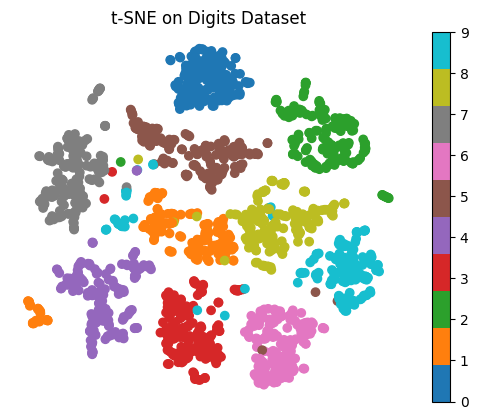

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
g1 = ax.scatter(Y[:, 0], Y[:, 1], c=y, cmap="tab10")
ax.axis("off")
ax.set_title("t-SNE on Digits Dataset")
plt.colorbar(g1, ax=ax)
plt.show()